In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline

import keras

import joblib

In [2]:
df = pd.read_csv('crop_yield.csv')
df.head()

,Crop,Precipitation,SpecificHumidity_g_kg,RelativeHumidity_%,Temperature_C,Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


### Pré-Processamento dos dados

Como já realizamos a análise exploratória dos dados, podemos partir para a preparação dos dados para o algoritmo de Machine Learning.

**Tratamento dos dados categóricos**

O parâmetro *drop-first=True* serve para evitar multicolinearidade entre os dados, ou seja, variáveis que se correlacionam entre si.

In [3]:
df = pd.get_dummies(df, columns=['Crop'], drop_first=True)

**Combinação das 2 features de humidade**

In [4]:
df['HumidityCombined'] = df['RelativeHumidity_%'] * df['SpecificHumidity_g_kg'] # Combinação das features

df.drop(['SpecificHumidity_g_kg', 'RelativeHumidity_%'], axis=1, inplace=True) # Excluindo valores de humidade anteriores
df.head()

,Precipitation,Temperature_C,Yield,Crop_Oil palm fruit,"Crop_Rice, paddy","Crop_Rubber, natural",HumidityCombined
0,2248.92,26.01,11560,False,False,False,1477.8480
1,1938.42,26.11,11253,False,False,False,1440.2094
2,2301.54,26.24,9456,False,False,False,1474.4899
3,2592.35,25.56,9321,False,False,False,1498.0827
4,2344.72,25.76,8800,False,False,False,1481.3532


**Separando variáveis independentes (X) da variável dependente (y)**

In [5]:
X = df[['Crop_Oil palm fruit', 'Crop_Rice, paddy', 'Precipitation', 'HumidityCombined', 'Temperature_C']]
y = df['Yield']

**Separação dos dados em treino e teste**

Método HoldOut, porém também faremos validação cruzada.

In [6]:
SEED = 80

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

**Normalização**

In [7]:
normalization = MinMaxScaler()

X_train = normalization.fit_transform(X_train)
X_test = normalization.transform(X_test)

### Treinamento com vários modelos

In [8]:
def view_scores(y_true, y_pred, title):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(title)
    print(f'MSE: {mse}')
    print(f'RMSE: {np.sqrt(mse)}')
    print(f'R² Score: {r2*100:.2f}')

In [9]:
def cros_validate_view_scores(results):
   mse_scores = -results['test_neg_mean_squared_error'].mean() # Realiza a média e converte para valores positivos
   r2_scores = results['test_r2'].mean() # Realiza a média e converte para valores positivos
   
   print(f'MSE: {mse_scores}')
   print(f'RMSE: {np.sqrt(mse_scores)}')
   print(f'R²: {r2_scores}')

In [10]:
kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)

#### Modelo Baseline

In [11]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

model_lr_predict = model_lr.predict(X_test)
view_scores(y_test, model_lr_predict, 'Modelo Baseline (Logistic Regression)')

Modelo Baseline (Logistic Regression)
MSE: 104920296.4095226
RMSE: 10243.060890648
R² Score: 98.41


**Validação cruzada**

OBS: Para problemas de regressão, é necessário utilizar o KFold.

In [12]:
pipeline_lr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', LinearRegression())
])

results_lr = cross_validate(pipeline_lr, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_lr)

MSE: 63796420.58010224
RMSE: 7987.266151825807
R²: 0.9857091410803847


#### Voting Regressor

In [13]:
base_models = [
    ('dt', DecisionTreeRegressor(random_state=SEED)),
    ('rt', RandomForestRegressor(n_estimators=100, random_state=SEED)),
    ('knn', KNeighborsRegressor()),
    ('svc', SVR()),
    ('lr', LinearRegression())
]

model_bg = VotingRegressor(estimators=base_models)
model_bg.fit(X_train, y_train)

model_bg_predict = model_bg.predict(X_test)
view_scores(y_test, model_bg_predict, 'Voting Regressor')

Voting Regressor
MSE: 569867124.5275605
RMSE: 23871.889839884076
R² Score: 91.35


**Validação Cruzada**

In [14]:
pipeline_vt = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', VotingRegressor(estimators=base_models))
])

results_vt = cross_validate(pipeline_vt, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_vt)

MSE: 326629122.63104314
RMSE: 18072.88362799482
R²: 0.9347059551639847


#### Stacking

In [15]:
model_st = StackingRegressor(estimators=base_models,
                             final_estimator=DecisionTreeRegressor(random_state=SEED))
model_st.fit(X_train, y_train)

model_st_predict = model_st.predict(X_test)
view_scores(y_test, model_st_predict, 'Stacking')

Stacking
MSE: 206480760.59375
RMSE: 14369.438423047366
R² Score: 96.87


**Validação Cruzada**

In [16]:
pipeline_stc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', StackingRegressor(estimators=base_models,
                             final_estimator=DecisionTreeRegressor(random_state=SEED)))
])

results_stc = cross_validate(pipeline_stc, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_stc)

MSE: 144103160.73208332
RMSE: 12004.297594281947
R²: 0.9713342627873043


#### Floresta Aleatória

In [17]:
model_rf = RandomForestRegressor(random_state=SEED)
model_rf.fit(X_train, y_train)

model_rf_predict = model_rf.predict(X_test)
view_scores(y_test, model_rf_predict, 'Floresta Aleatória')

Floresta Aleatória
MSE: 115633352.57091635
RMSE: 10753.29496344801
R² Score: 98.25


**Validação Cruzada**

In [18]:
pipeline_rf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', RandomForestRegressor(random_state=SEED))
])

results_rf = cross_validate(pipeline_rf, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_rf)

MSE: 56225466.882245764
RMSE: 7498.364280444486
R²: 0.9878509996350626


#### Bagging Regressor

In [19]:
model_bg = BaggingRegressor(estimator=LinearRegression(), random_state=SEED)
model_bg.fit(X_train, y_train)

model_bg_predict = model_bg.predict(X_test)
view_scores(y_test, model_bg_predict, 'Bagging Regressor')

Bagging Regressor
MSE: 105016428.0835991
RMSE: 10247.75234300669
R² Score: 98.41


**Validação Cruzada**

In [20]:
pipeline_bg = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', BaggingRegressor(estimator=LinearRegression(), random_state=SEED))
])

results_bg = cross_validate(pipeline_bg, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_bg)

MSE: 63243434.74110867
RMSE: 7952.574095291956
R²: 0.9857591418519032


#### XGBoost

In [21]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

model_xgb_predict = model_xgb.predict(X_test)
view_scores(y_test, model_xgb_predict, 'XGBoost Regressor')

XGBoost Regressor
MSE: 104275771.64785266
RMSE: 10211.550893368385
R² Score: 98.42


**Validação Cruzada**

In [22]:
pipeline_xgb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', XGBRegressor())
])

results_xgb = cross_validate(pipeline_xgb, X, y,
                            cv=kfold,
                            scoring=['neg_mean_squared_error', 'r2'])
cros_validate_view_scores(results_xgb)

MSE: 78923854.00488426
RMSE: 8883.90983772822
R²: 0.9830909132957458


#### Redes Neurais

Apesar de redes neurais serem poderosas, nem sempre é a melhor escolha.

In [23]:
model_keras = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model_keras.compile(optimizer=keras.optimizers.Adam(),
                    loss=keras.losses.MeanSquaredError(),
                    metrics=[keras.metrics.R2Score(), keras.metrics.RootMeanSquaredError()])

model_keras.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,313 (177.00 KB)

 Trainable params: 45,313 (177.00 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
             keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='checkpoint_best_model.keras', save_best_only=True)]

In [26]:
history = model_keras.fit(X_train, y_train,
                epochs=150,
                batch_size=32,
                validation_data=(X_test, y_test),
                callbacks=callbacks)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 6634391552.0000 - r2_score: -0.5416 - root_mean_squared_error: 81439.7188 - val_loss: 13003982848.0000 - val_r2_score: -0.9734 - val_root_mean_squared_error: 114035.0078
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6304685056.0000 - r2_score: -0.5766 - root_mean_squared_error: 78494.1719 - val_loss: 13003868160.0000 - val_r2_score: -0.9734 - val_root_mean_squared_error: 114034.5078
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6292566528.0000 - r2_score: -0.5611 - root_mean_squared_error: 79194.4453 - val_loss: 13003671552.0000 - val_r2_score: -0.9734 - val_root_mean_squared_error: 114033.6406
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7695609856.0000 - r2_score: -0.6347 - root_mean_squared_error: 87608.0234 - val_loss: 13003325440.0000 - val_r2_score: -0.9733 - val_root_mean_squared_error: 114032.1250
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6462177280.0000 - r2_score: -0

In [27]:
predict_keras_train = model_keras.predict(X_train)
predict_keras_test = model_keras.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [28]:
history.history.keys()

dict_keys(['loss', 'r2_score', 'root_mean_squared_error', 'val_loss', 'val_r2_score', 'val_root_mean_squared_error'])

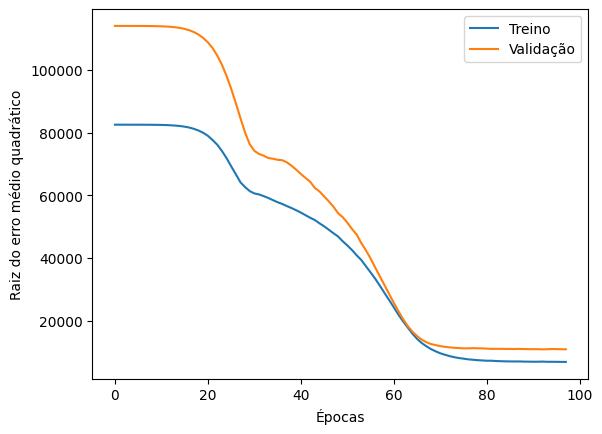

In [29]:
# MSE (RMSE) -> Quanto menor, melhor
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.xlabel('Épocas')
plt.ylabel('Raiz do erro médio quadrático')
plt.legend(['Treino','Validação'])

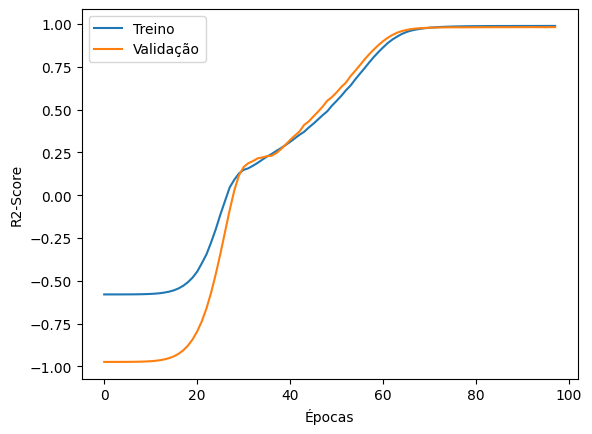

In [30]:
# R² Score -> Quanto maior, melhor
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
plt.xlabel('Épocas')
plt.ylabel('R2-Score')
plt.legend(['Treino','Validação'])

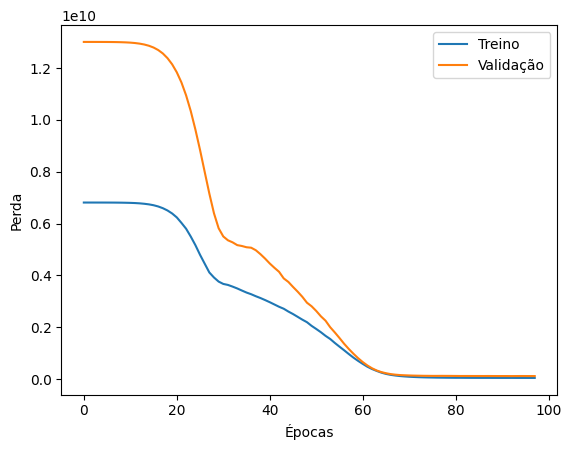

In [31]:
# Valor de perda -> Quanto menor, melhor
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(['Treino','Validação'])

Text(0.5, 0, 'Rendimentos')

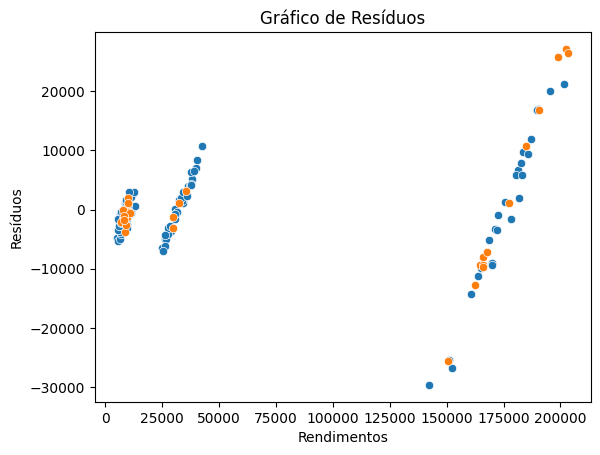

In [32]:
resid_train = y_train - predict_keras_train.reshape(-1) # flatten() tbm funciona para reduzir as dimensões do array
resid_test = y_test - predict_keras_test.reshape(-1)

sns.scatterplot(x=y_train, y=resid_train)
sns.scatterplot(x=y_test, y=resid_test)
plt.title("Gráfico de Resíduos")
plt.ylabel("Resíduos")
plt.xlabel("Rendimentos")

### Treinando o melhor modelo

Iremos treinar o melhor modelo baseado nas métricas adquiridas no processo de validação cruzada. O algorítmo de **Floresta Aleatória** foi o melhor modelo.

In [33]:
# Modelos como o de floresta aleatória não é necessário normalizar os dados

final_model_rf = RandomForestRegressor(random_state=SEED)
final_model_rf.fit(X, y)

joblib.dump(final_model_rf, 'random_forest_model.joblib')

['random_forest_model.joblib']